In [1]:
# (c) Charles Le Losq 2021
# see embedded licence file

# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())
      
device = 'cpu'
print(device)

import imelt

# scaling coefficients for loss function
# viscosity is always one
# scaling coefficients for loss function
# viscosity is always one
ls = imelt.loss_scales()        
entro_scale = ls.entro
raman_scale = ls.raman
density_scale = ls.density
ri_scale = ls.ri
tg_scale = ls.tg

CUDA AVAILABLE?  True
cpu


# Size of dataset analysis

Here we trained 10 networks for each train dataset size.

We will select the best ones for each dataset size, and report the RMSE for viscosity for the training and validation reference data subset.

In [2]:
# Data import
prefix= ["0p10val","0p20val","0p30val","0p40val","0p50val","0p60val","0p70val","0p80val"]

suffix = ["_0","_1","_2","_3","_4","_5","_6","_7","_8","_9"]

# variable to record the results
total_size_train = np.zeros(len(prefix))
compo_size_train = np.zeros(len(prefix))
# order for errors is AG, MYEGA, A-M, CG, TVF, Raman, Density, Entropy, Refractivce Index
error_size_train = np.zeros((len(prefix),len(suffix),9))
error_size_valid = np.zeros((len(prefix),len(suffix),9))

# scaling coefficients
scaling = np.array([[1., 1., 1., 1., 1., raman_scale, density_scale, entro_scale, ri_scale]])
print(scaling.shape)

# Loading the reference dataset
ds = imelt.data_loader("./data/NKAS_viscosity_reference.hdf5",
                             "./data/NKAS_Raman.hdf5",
                             "./data/NKAS_density.hdf5",
                             "./data/NKAS_optical.hdf5",
                             device)

# Loss criterion
criterion = torch.nn.MSELoss()

for j in range(len(prefix)): # main loop: between datasets

    # Load the dataset used for training, to get the number of compositions
    dataset_name = "./data/NKAS_viscosity_{}.hdf5".format(prefix[j])
    ds_ = imelt.data_loader(dataset_name,
                             "./data/NKAS_Raman.hdf5",
                             "./data/NKAS_density.hdf5",
                             "./data/NKAS_optical.hdf5",
                             device)
    
    # saving in output variables
    total_size_train[j] = len(ds_.T_visco_train)
    compo_size_train[j] = np.unique(ds_.x_visco_train,axis=0).shape[0]
    
    for i in range(len(suffix)): # subloop: between each different training on one dataset
        
        # Loading the network and freezing dropout
        name_model = "model_l4_n200_p0_data{}{}.pth".format(prefix[j],suffix[i])
        neuralmodel = imelt.model(4,200,4,ds.nb_channels_raman,p_drop=0.01) 
        neuralmodel.load_state_dict(torch.load("./model/exp_trainsize/"+name_model, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
        
        # PREDICTIONS
        with torch.set_grad_enabled(False):
    
            # train
            y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
            y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
            y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
            y_cg_pred_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
            y_tvf_pred_train = neuralmodel.tvf(ds.x_visco_train,ds.T_visco_train)
            y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
            y_density_pred_train = neuralmodel.density(ds.x_density_train)
            y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
            y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

            # valid
            y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
            y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
            y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
            y_cg_pred_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
            y_tvf_pred_valid = neuralmodel.tvf(ds.x_visco_valid,ds.T_visco_valid)
            y_raman_pred_valid = neuralmodel.raman_pred(ds.x_raman_valid)
            y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
            y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
            y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)

            # Compute Loss

            # train 
            error_size_train[j,i,0]  = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,1]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,2]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
            error_size_train[j,i,3]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
            error_size_train[j,i,4]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
            error_size_train[j,i,5]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())

            # validation
            error_size_valid[j,i,0] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,1] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,2] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
            error_size_valid[j,i,3] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
            error_size_valid[j,i,4] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
            error_size_valid[j,i,5] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())

(1, 9)


# Architecture results

In [3]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["name"] = list_models

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)

record_loss["loss_cg_train"] = np.zeros(nb_exp)
record_loss["loss_cg_valid"] = np.zeros(nb_exp)

record_loss["loss_tvf_train"] = np.zeros(nb_exp)
record_loss["loss_tvf_valid"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

record_loss["loss_train"] = np.zeros(nb_exp)
record_loss["loss_valid"] = np.zeros(nb_exp)

### Load dataset

path_data = "./data/NKAS_viscosity_reference.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = imelt.data_loader(path_data,path_raman,path_density,path_optical,device)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    with torch.set_grad_enabled(False):
        # train
        y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
        y_myega_pred_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
        y_am_pred_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
        y_cg_pred_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
        y_tvf_pred_train = neuralmodel.tvf(ds.x_visco_train,ds.T_visco_train)
        y_raman_pred_train = neuralmodel.raman_pred(ds.x_raman_train)
        y_density_pred_train = neuralmodel.density(ds.x_density_train)
        y_entro_pred_train = neuralmodel.sctg(ds.x_entro_train)
        y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train, ds.lbd_ri_train)

        # valid
        y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
        y_myega_pred_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
        y_am_pred_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
        y_cg_pred_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
        y_tvf_pred_valid = neuralmodel.tvf(ds.x_visco_valid,ds.T_visco_valid)
        y_density_pred_valid = neuralmodel.density(ds.x_density_valid)
        y_entro_pred_valid = neuralmodel.sctg(ds.x_entro_valid)
        y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid, ds.lbd_ri_valid)

        # Compute Loss

        # train 
        record_loss.loc[idx,"loss_ag_train"] = np.sqrt(criterion(y_ag_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_myega_train"]  = np.sqrt(criterion(y_myega_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_am_train"]  = np.sqrt(criterion(y_am_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_cg_train"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_tvf_train"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_raman_train"]  = np.sqrt(criterion(y_raman_pred_train,ds.y_raman_train).item())
        record_loss.loc[idx,"loss_d_train"]  = np.sqrt(criterion(y_density_pred_train,ds.y_density_train).item())
        record_loss.loc[idx,"loss_Sconf_train"]  = np.sqrt(criterion(y_entro_pred_train,ds.y_entro_train).item())
        record_loss.loc[idx,"loss_ri_train"]  = np.sqrt(criterion(y_ri_pred_train,ds.y_ri_train).item())

        # validation
        record_loss.loc[idx,"loss_ag_valid"] = np.sqrt(criterion(y_ag_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_myega_valid"] = np.sqrt(criterion(y_myega_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_am_valid"] = np.sqrt(criterion(y_am_pred_valid, ds.y_visco_valid).item())
        record_loss.loc[idx,"loss_cg_valid"]  = np.sqrt(criterion(y_cg_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_tvf_valid"]  = np.sqrt(criterion(y_tvf_pred_train, ds.y_visco_train).item())
        record_loss.loc[idx,"loss_raman_valid"] = np.sqrt(criterion(y_raman_pred_valid,ds.y_raman_valid).item())
        record_loss.loc[idx,"loss_d_valid"] = np.sqrt(criterion(y_density_pred_valid,ds.y_density_valid).item())
        record_loss.loc[idx,"loss_Sconf_valid"] = np.sqrt(criterion(y_entro_pred_valid,ds.y_entro_valid).item())
        record_loss.loc[idx,"loss_ri_valid"]  = np.sqrt(criterion(y_ri_pred_valid,ds.y_ri_valid).item())
    
    record_loss.loc[idx,"loss_train"] = (record_loss.loc[idx,"loss_ag_train"] + 
                                         record_loss.loc[idx,"loss_myega_train"] + 
                                         record_loss.loc[idx,"loss_am_train"] + 
                                         record_loss.loc[idx,"loss_cg_train"] + 
                                         record_loss.loc[idx,"loss_tvf_train"] + 
                                         raman_scale*record_loss.loc[idx,"loss_raman_train"] + 
                                         density_scale*record_loss.loc[idx,"loss_d_train"] + 
                                         entro_scale*record_loss.loc[idx,"loss_Sconf_train"] + 
                                         ri_scale*record_loss.loc[idx,"loss_ri_train"])
    
    record_loss.loc[idx,"loss_valid"] = (record_loss.loc[idx,"loss_ag_valid"] + 
                                         record_loss.loc[idx,"loss_myega_valid"] + 
                                         record_loss.loc[idx,"loss_am_valid"] + 
                                         record_loss.loc[idx,"loss_cg_valid"] + 
                                         record_loss.loc[idx,"loss_tvf_valid"] + 
                                         raman_scale*record_loss.loc[idx,"loss_raman_valid"] + 
                                         density_scale*record_loss.loc[idx,"loss_d_valid"] + 
                                         entro_scale*record_loss.loc[idx,"loss_Sconf_valid"] + 
                                         ri_scale*record_loss.loc[idx,"loss_ri_valid"])

# Supplementary Figure 1 : architecture and training dataset size tests

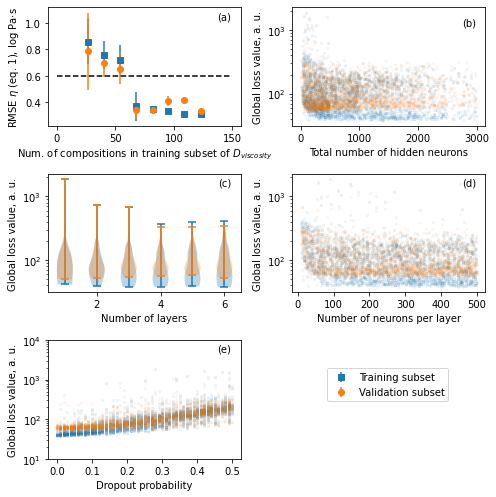

In [4]:
plt.figure(figsize=(7,7))

ax = plt.subplot(3,2,1)

plt.errorbar(compo_size_train, 
             np.median(error_size_train[:,:,1], axis=1),
             yerr=np.std(error_size_train[:,:,1], axis=1),fmt="s", color="C0", label="Training subset")
plt.errorbar(compo_size_train, 
             np.median(error_size_valid[:,:,1], axis=1),
             yerr=np.std(error_size_valid[:,:,1], axis=1),fmt="o", color="C1", label = "Validation subset")
plt.plot([0,150],[0.6,0.6],"k--")
#plt.xlim(10,120)

plt.annotate("(a)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")
plt.xlabel("Num. of compositions in training subset of $D_{viscosity}$")
plt.ylabel("RMSE $\eta$ (eq. 1), log Pa$\cdot$s")

plt.subplot(3,2,2)
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_train"],
         "s",alpha=0.05,ms=2,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_valid"],
         "o",alpha=0.05,ms=2,color="C1")

plt.yscale('log')

plt.xlabel("Total number of hidden neurons")
plt.ylabel("Global loss value, a. u.")
plt.annotate("(b)",xy=(0.95,0.85),xycoords="axes fraction",ha="right")
plt.tight_layout()

plt.subplot(3,2,3)
plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_train"].values for i in range(1,7)],
               [i for i in range(1,7)])

plt.violinplot([record_loss.loc[record_loss["nb_layers"]==i,"loss_valid"].values for i in range(1,7)],
               [i for i in range(1,7)])

plt.yscale('log')
#plt.ylim(0.01,10000)

plt.xlabel("Number of layers")
plt.ylabel("Global loss value, a. u.")
plt.annotate("(c)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,2,4)
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_train"],"s",alpha=0.05,markersize=2,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"],record_loss.loc[:,"loss_valid"],"o",alpha=0.05,markersize=2,color="C1")
plt.yscale('log')

#plt.ylim(0.01,10000)

plt.xlabel("Number of neurons per layer")
plt.ylabel("Global loss value, a. u.")
           
plt.annotate("(d)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.subplot(3,2,5)
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_train"],"s",color="C0",alpha=0.05,markersize=2,label="Training subset")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_valid"],"o",color="C1",alpha=0.05,markersize=2,label="Validation subset")
plt.yscale('log')


plt.ylim(10,10000)

plt.annotate("(e)",xy=(0.95,0.9),xycoords="axes fraction",ha="right")

plt.xlabel("Dropout probability")
plt.ylabel("Global loss value, a. u.")

plt.tight_layout()
ax.legend(fancybox=True,bbox_to_anchor=(2.1, -2.))

plt.savefig("./figures/SupplementaryFigure_1_architecture.pdf")

# Detect and save best architestures

In [12]:
# For that we use the global "loss_valid" = loss_viscosity + loss_raman + loss_density + loss_refractiveindex
# best_recorded = record_loss[(record_loss.nb_layers>2)&(record_loss.nb_layers<7)].nsmallest(10,"loss_valid")

# # importing shutil module  
# import shutil 

# Copy the content of 
# source to destination 
# for i in best_recorded.loc[:,"name"]:
#     shutil.copyfile("./model/exp_arch/"+i, "./model/best/"+i) 

# best_recorded.to_csv("./model/best/best_list.csv")